C:\Users\Armin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


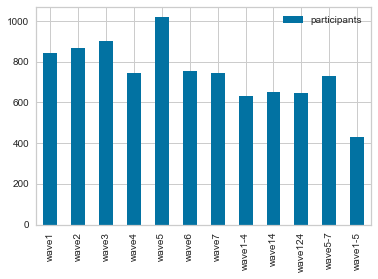

In [1]:
#MVPA 1-3

import numpy as np
import pandas as pd
import pandas_profiling as pp
from IPython.display import display, HTML
import pymannkendall as mk
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import KFold, cross_val_score
from itertools import combinations
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import ipynb.fs.full.script
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from statsmodels.sandbox.regression.predstd import wls_prediction_std


%matplotlib inline
pd.options.display.max_columns = None

pd.options.display.max_rows = 10
pd.options.display.width = 200
np.set_printoptions(precision = 4, suppress = True) 

legit_classes1 = [67,71,72,74,77,78,79,81,83,86,100,101,103,121,122,125,126,127,129,130,131,133,135,138]
legit_classes2 = [73,74,78,81,82,86,100,103,124,125,131,133,135,141,250,251,256,258,259,261,262,263,272,273,277,279,290,291,292,296,297,298,299,300,301,302,303,304,305,306,307,308,310]
participants = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/8. Metadata/Participant_Info.csv", sep= ';')

par_w1 = participants["W1"] == 1
par_w2 = participants["W2"] == 1
par_w3 = participants["W3"] == 1
par_w4 = participants["W4"] == 1
par_w5 = participants["W5"] == 1
par_w6 = participants["W6"] == 1
par_w7 = participants["W7"] == 1

total1 = len(participants[par_w1])
total2 = len(participants[par_w3])
total3 = len(participants[par_w2])
total4 = len(participants[par_w4])
total5 = len(participants[par_w5])
total6 = len(participants[par_w6])
total7 = len(participants[par_w7])
total1_4 = len(participants[par_w1 & par_w2 & par_w3 & par_w4])
total14 = len(participants[par_w1 & par_w4])
total124 = len(participants[par_w1 & par_w2 & par_w4])
total5_7 = len(participants[par_w5 & par_w6 & par_w7])
total1_5 = len(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5])

par_per_wave = pd.DataFrame({
    'participants': [total1, total2, total3, total4, total5, total6, total7, total1_4, total14, total124, total5_7, total1_5]}, index=['wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'wave6', 'wave7', 'wave1-4', 'wave14','wave124', 'wave5-7', 'wave1-5'])

par_per_wave.plot.bar()


#display(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5 & par_w6 & par_w7])
#print(participants[par_w1 & par_w2 & par_w3 & par_w4].count)

In [2]:
#getting participants from 1 to 3
participants1_3 = participants[['Child','Class_Y1']][par_w1 & par_w2 & par_w3]
participants1_3 = participants1_3[participants1_3["Class_Y1"].isin(legit_classes1)]
par_13 = participants1_3
participants1_3 = participants1_3["Child"].tolist()
schools = participants['School'][participants['Child'].isin(participants1_3)].unique().tolist()
display(schools)

[25, 26, 27, 29, 28, 30, 32, 33, 34, 37, 39, 42, 40]

In [3]:
#fit
#compare waves with eachother as percentage for example
fit_clean = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/5. Fitbit data/Fitbit_W17_cleaned_imputation.csv", sep= ';')
fit_clean1_3 = fit_clean[fit_clean["Child"].isin(participants1_3)]

fit_clean1_3 = fit_clean1_3[fit_clean1_3["Wave"] <= 3]

fit_clean1_3 = fit_clean1_3.drop(columns = ['Imputed','Participated'])
fit_clean1_3 = fit_clean1_3.sort_values(['Child','Wave', 'Day'])
display(fit_clean1_3[fit_clean1_3['Child'] == 1222])

,School,Class,Child,Sex,Age,Wave,Day,Date,Steps,Minutes_MVPA
1726,25,67,1222,1,11.0,1,1,28-1-2016,12620.0,0.0
1727,25,67,1222,1,11.0,1,2,29-1-2016,4601.0,0.0
1728,25,67,1222,1,11.0,1,3,30-1-2016,3498.0,0.0
1729,25,67,1222,1,12.0,2,1,31-3-2016,7554.0,17.0
1730,25,67,1222,1,12.0,2,2,1-4-2016,6924.0,13.0
1731,25,67,1222,1,12.0,2,3,2-4-2016,3665.0,0.0
1734,25,67,1222,1,12.0,3,1,1-6-2016,8011.0,10.0
1733,25,67,1222,1,12.0,3,2,2-6-2016,1702.0,0.0
1732,25,67,1222,1,12.0,3,3,3-6-2016,2845.0,0.0


In [4]:
# get the average amount of MVPA per child over wave 1-3
avg_MVPA_13 = fit_clean1_3[['School', 'Class', 'Child', 'Wave','Day','Minutes_MVPA']].copy()
avg_MVPA_13 = avg_MVPA_13.groupby('Child').mean()
avg_MVPA_13 = avg_MVPA_13.drop(columns = ['Wave', 'Day', 'Class', 'School'])
avg_MVPA_13.reset_index()

full_table_13 = avg_MVPA_13
full_table_13 = full_table_13.reset_index()
temp = fit_clean1_3.drop(columns = ['Steps', 'Date', 'Minutes_MVPA', 'Day', 'Wave'])
temp = temp.drop_duplicates(subset = ["Child"])

full_table_13 = full_table_13.merge(temp)
full_table_13

,Child,Minutes_MVPA,School,Class,Sex,Age
0,1222,4.444444,25,67,1,11.0
1,1224,25.142857,25,67,1,12.0
2,1225,59.733333,25,67,0,11.0
3,1226,40.785714,25,67,1,11.0
4,1227,18.000000,25,67,1,12.0
...,...,...,...,...,...,...
355,3188,87.076923,40,135,0,10.0
356,3189,16.923077,40,135,1,9.0
357,3190,63.000000,40,135,1,9.0
358,3191,44.000000,40,135,1,9.0


In [5]:
#socio
socio_gbl_123 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves123.xlsx", sep= ';')
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_lcl_123 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves123.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')

socio_lcl_123 = socio_lcl_123.rename(columns={"Node": "Child"})
socio_lcl_123 = socio_lcl_123.drop(['Unnamed: 0', 'ClusteringC'], axis = 1)
socio_gbl_123 = socio_gbl_123.drop(['Unnamed: 0'], axis = 1)

#Add socio data to the full table of week 1-3
full_table_13 = full_table_13.merge(socio_lcl_123, how = 'left')
full_table_13 = full_table_13.merge(socio_gbl_123, how = 'left')
display(full_table_13)
children = full_table_13['Child']

,Child,Minutes_MVPA,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes
0,1222,4.444444,25,67,1,11.0,0.024125,0.772727,1.470588,0.238135,1.330065,0.669935,205,18
1,1224,25.142857,25,67,1,12.0,0.017039,0.772727,1.294118,0.240811,1.330065,0.669935,205,18
2,1225,59.733333,25,67,0,11.0,0.006038,0.708333,1.058824,0.195491,1.330065,0.669935,205,18
3,1226,40.785714,25,67,1,11.0,0.021561,0.680000,1.529412,0.179114,1.330065,0.669935,205,18
4,1227,18.000000,25,67,1,12.0,0.000460,0.680000,1.000000,0.179114,1.330065,0.669935,205,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,3188,87.076923,40,135,0,10.0,0.011512,0.944444,1.941176,0.247409,1.111111,0.888889,272,18
356,3189,16.923077,40,135,1,9.0,0.014462,0.944444,1.941176,0.248110,1.111111,0.888889,272,18
357,3190,63.000000,40,135,1,9.0,0.005054,1.000000,1.764706,0.262937,1.111111,0.888889,272,18
358,3191,44.000000,40,135,1,9.0,0.016198,1.000000,2.000000,0.262937,1.111111,0.888889,272,18


In [6]:
#questionnaire 
questionnaire_1 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W1_Main_questions.csv", sep= ';')
questionnaire_2 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W2_Main_questions.csv", sep= ';')
questionnaire_3 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W3_Main_questions.csv", sep= ';')
questionnaire_123 = questionnaire_1.merge(questionnaire_2, on = 'Child')
questionnaire_123 = questionnaire_123.merge(questionnaire_3, on = 'Child')
#display(questionnaire_123.filter(regex=("ME_Internet_Game_Exposure_ME_SM.*")))

questionnaire_123 = questionnaire_123[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x','PA_motivation_PA_motiv_.extrin1_x', 
                                       'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']]
temp = questionnaire_2.loc[:, questionnaire_2.columns.str.contains('facili')]
temp['Child'] = ""
temp = questionnaire_2[temp.columns]
temp = temp.set_index('Child')

# Give a 0 or 1 value for each facility wether it is or is not in the enviroment of the child
for index, row in temp.iterrows():
    temp.loc[index,'Bos'] = row.str.contains('Bos').any()
    temp.loc[index,'Park'] = row.str.contains('Park').any()
    temp.loc[index,'Speelplein'] = row.str.contains('Speelplein').any()
    temp.loc[index,'Speeltuin'] = row.str.contains('Speeltuin').any()
    temp.loc[index,'Sportschool'] = row.str.contains('Sportschool').any()
    temp.loc[index,'Sportclub'] = row.str.contains('Sportclub').any()
    temp.loc[index,'Zwembad'] = row.str.contains('Zwembad').any()
    temp.loc[index,'Meer_zee'] = row.str.contains('Meer_zee').any()
    temp.loc[index,'Dansschool'] = row.str.contains('Dansschool').any()
    temp.loc[index,'Sporthal'] = row.str.contains('Sporthal').any()
    temp.loc[index,'Grasveld'] = row.str.contains('Grasveld').any()
    
temp.drop(temp.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]],axis=1,inplace=True)
temp = temp.astype(int)
questionnaire_123 = questionnaire_123[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x','PA_motivation_PA_motiv_.intrin2_x', 
                                       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 
                                       'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']].dropna()
questionnaire_123 = questionnaire_123.loc[questionnaire_123['Child'].isin(children)]
questionnaire_123.drop_duplicates()


C:\Users\Armin\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Child,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1814,1.0,5.0,4.0,1.0,6.0,2.0,1.0
1,1815,7.0,6.0,1.0,1.0,6.0,4.0,2.0
2,1819,1.0,6.0,4.0,1.0,6.0,3.0,6.0
3,3161,6.0,6.0,6.0,1.0,6.0,3.0,1.0
6,1428,4.0,6.0,1.0,1.0,5.0,3.0,1.0
...,...,...,...,...,...,...,...,...
896,2987,6.0,5.0,1.0,1.0,6.0,3.0,1.0
897,2988,7.0,1.0,1.0,1.0,1.0,8.0,6.0
898,2990,7.0,4.0,1.0,1.0,5.0,5.0,2.0
916,3084,7.0,4.0,1.0,1.0,6.0,4.0,1.0


In [7]:
temp = temp.reset_index()
full_table_13 = full_table_13.merge(temp)

# merge with the barrier question
temp = questionnaire_123
full_table_13 = full_table_13.merge(temp)
display(full_table_13)

full_table_13['PA_Barriers_Resource_place_1'] = full_table_13['PA_Barriers_Resource_place_1'].fillna(method = 'ffill')
display(full_table_13['Age'].value_counts())


,Child,Minutes_MVPA,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1222,4.444444,25,67,1,11.0,0.024125,0.772727,1.470588,0.238135,1.330065,0.669935,205,18,1,1,0,1,1,1,0,1,1,1,1,7.0,5.0,4.0,4.0,4.0,6.0,1.0
1,1224,25.142857,25,67,1,12.0,0.017039,0.772727,1.294118,0.240811,1.330065,0.669935,205,18,0,1,0,1,0,1,1,0,1,0,1,7.0,6.0,1.0,1.0,6.0,2.0,1.0
2,1225,59.733333,25,67,0,11.0,0.006038,0.708333,1.058824,0.195491,1.330065,0.669935,205,18,0,1,1,0,1,0,0,1,0,0,1,7.0,3.0,1.0,1.0,5.0,6.0,3.0
3,1226,40.785714,25,67,1,11.0,0.021561,0.680000,1.529412,0.179114,1.330065,0.669935,205,18,0,1,0,1,0,1,0,1,0,0,1,5.0,6.0,1.0,1.0,6.0,3.0,1.0
4,1227,18.000000,25,67,1,12.0,0.000460,0.680000,1.000000,0.179114,1.330065,0.669935,205,18,1,0,0,0,0,0,0,1,0,0,0,7.0,6.0,1.0,1.0,6.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,3188,87.076923,40,135,0,10.0,0.011512,0.944444,1.941176,0.247409,1.111111,0.888889,272,18,0,0,0,1,1,1,1,0,0,1,1,7.0,6.0,1.0,1.0,6.0,3.0,2.0
284,3189,16.923077,40,135,1,9.0,0.014462,0.944444,1.941176,0.248110,1.111111,0.888889,272,18,0,1,1,1,1,1,1,0,1,1,1,3.0,6.0,1.0,1.0,6.0,2.0,1.0
285,3190,63.000000,40,135,1,9.0,0.005054,1.000000,1.764706,0.262937,1.111111,0.888889,272,18,1,0,1,0,0,1,0,0,0,0,1,2.0,4.0,1.0,1.0,6.0,2.0,2.0
286,3191,44.000000,40,135,1,9.0,0.016198,1.000000,2.000000,0.262937,1.111111,0.888889,272,18,0,1,1,0,0,0,0,0,1,0,1,6.0,6.0,1.0,1.0,6.0,2.0,1.0


9.0     82
10.0    78
12.0    63
11.0    53
13.0    11
8.0      1
Name: Age, dtype: int64

In [8]:
full_table_13.columns
pd.set_option('display.max_rows', None)
display(full_table_13.corr() ['Minutes_MVPA'])
pd.set_option('display.max_rows', 10)

Child                                       0.102867
Minutes_MVPA                                1.000000
School                                      0.066453
Class                                       0.090032
Sex                                        -0.434033
Age                                        -0.085801
Betweeness                                  0.172890
Closeness                                   0.193539
Degree                                      0.133219
Eigenvector                                 0.241282
Avg_Short_Path                             -0.035585
Density                                     0.076795
Edges                                      -0.116512
Nodes                                      -0.147358
Bos                                         0.009134
Park                                       -0.051863
Speelplein                                  0.105097
Speeltuin                                   0.019253
Sportschool                                 0.

In [9]:
full_table_13.describe()

,Child,Minutes_MVPA,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2219.604167,54.948369,33.246528,100.940972,0.489583,10.444444,0.017020,0.783305,1.465138,0.229347,1.248400,0.719546,257.611111,18.965278,0.291667,0.510417,0.625000,0.802083,0.357639,0.447917,0.489583,0.194444,0.288194,0.475694,0.798611,5.673611,5.173611,1.420139,1.500000,5.569444,4.003472,1.895833
std,702.037847,36.557552,6.081759,25.455159,0.500762,1.228453,0.019000,0.106257,0.330268,0.050302,0.141736,0.114683,140.768330,4.290681,0.455321,0.500762,0.484966,0.399123,0.480139,0.498146,0.500762,0.396461,0.453710,0.500278,0.401736,1.856638,1.270572,1.150917,1.221184,1.009728,1.829869,1.466080
min,1222.000000,0.000000,25.000000,67.000000,0.000000,8.000000,0.000000,0.489815,0.375000,0.072627,0.911765,0.458333,65.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1623.750000,30.013986,28.000000,78.000000,0.000000,9.000000,0.005054,0.703704,1.228632,0.197134,1.127273,0.650000,205.000000,17.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,5.000000,1.000000,1.000000,6.000000,3.000000,1.000000
50%,2266.000000,48.625000,33.000000,100.000000,0.000000,10.000000,0.010421,0.769231,1.526316,0.225443,1.219780,0.708791,230.000000,20.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,4.000000,1.000000
75%,2975.250000,69.989510,40.000000,130.000000,1.000000,12.000000,0.021249,0.852071,1.733333,0.262521,1.347953,0.800000,272.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,5.000000,2.000000
max,3192.000000,357.444444,42.000000,138.000000,1.000000,13.000000,0.113519,1.000000,2.000000,0.423749,1.518333,0.902778,663.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,6.000000,6.000000,6.000000,6.000000,9.000000,6.000000


C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


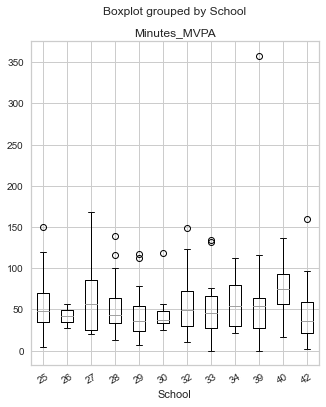

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


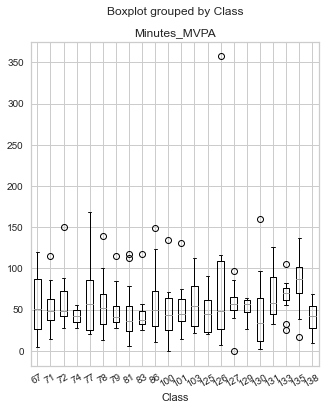

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


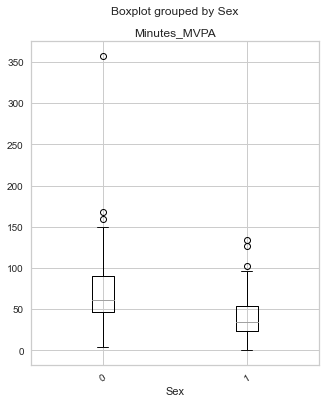

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


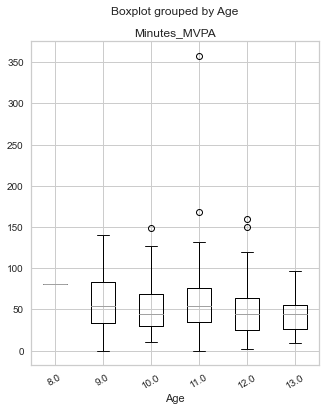

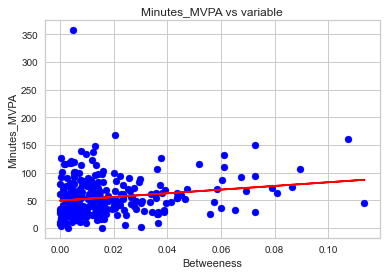

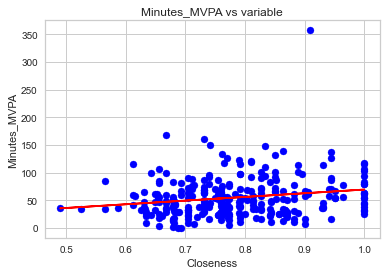

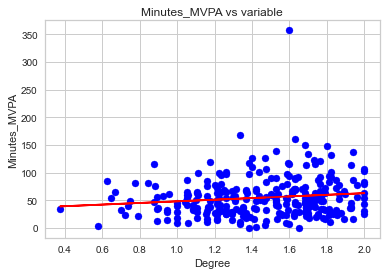

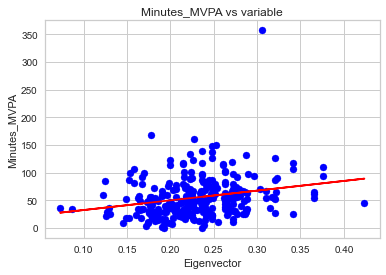

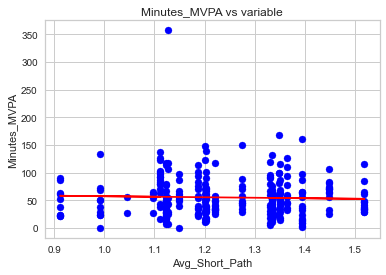

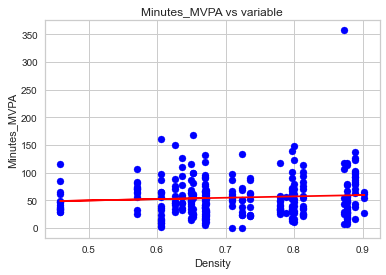

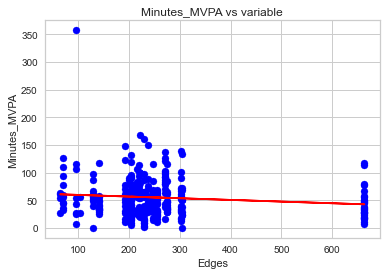

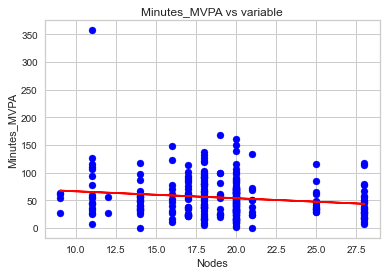

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


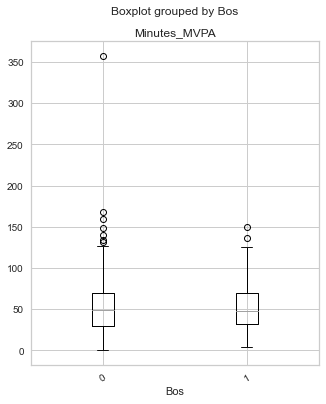

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


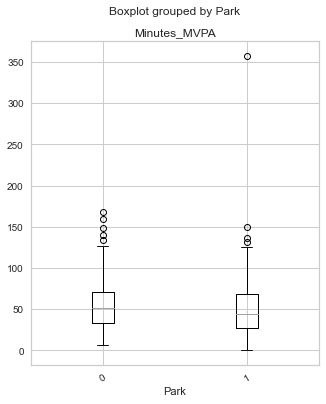

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


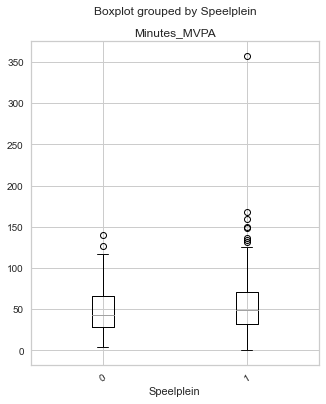

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


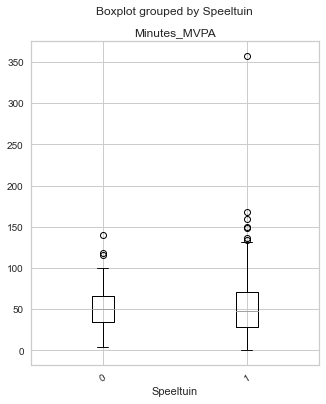

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


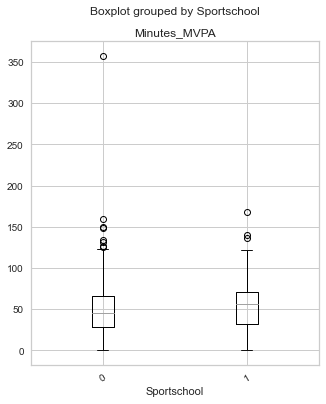

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


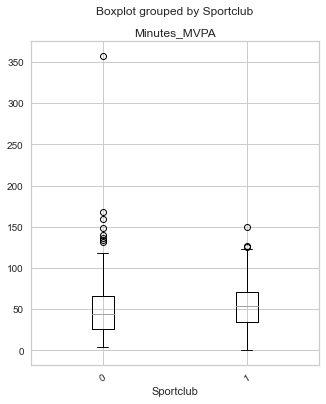

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


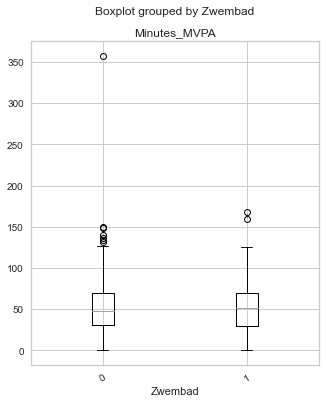

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


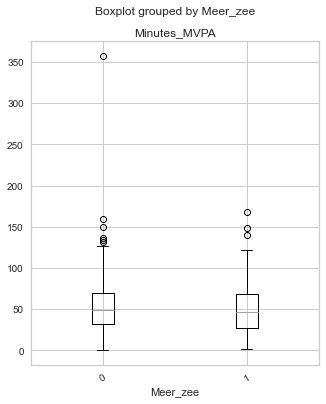

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


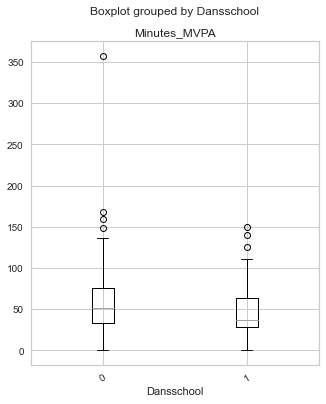

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


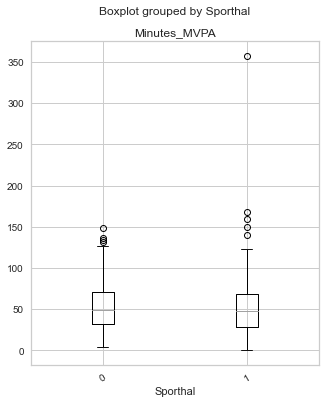

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


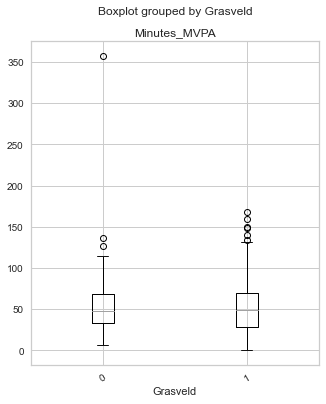

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


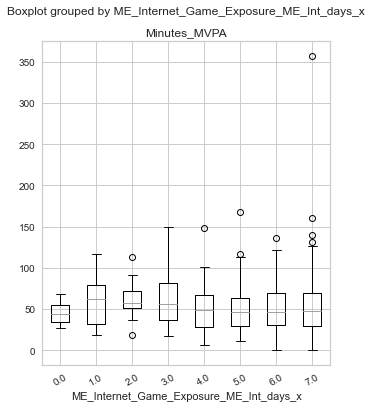

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


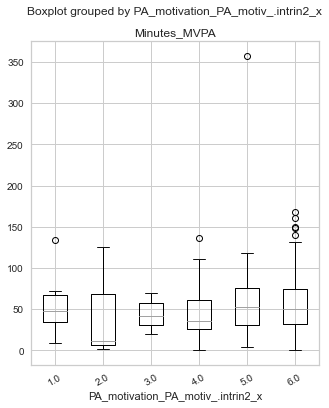

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


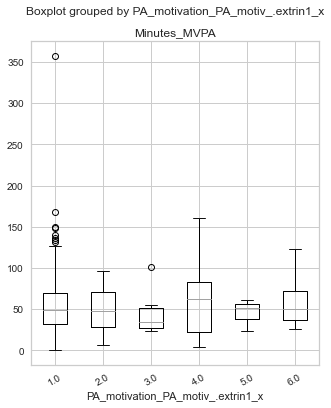

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


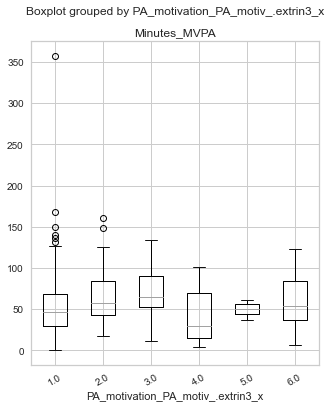

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


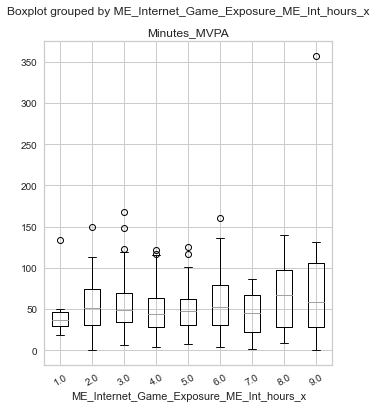

C:\Users\Armin\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


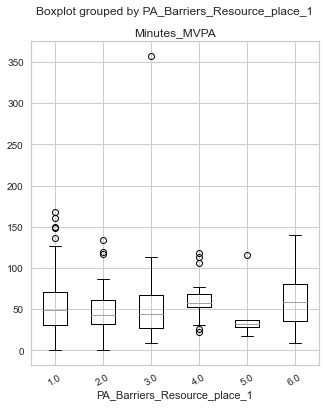

In [10]:
features = full_table_13.drop(columns = ['Minutes_MVPA'])
label = full_table_13['Minutes_MVPA']
ipynb.fs.full.script.trend_correlation_MVPA(features, label)

In [11]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_regression
X = full_table_13.drop(columns = ['Minutes_MVPA'])
y = full_table_13['Minutes_MVPA']

test = SelectKBest(score_func=f_regression, k=6)
fit = test.fit(X, y)
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)

# summarize selected features
print(features[0:5,:])
display(X.columns)
#X = X[['Sex', 'Age', 'Betweeness', 'Closeness', 'Eigenvector', 'Avg_Short_Path', 'Bos', 'Park', 'Speeltuin', 'Sportclub']]
X.corr()

[ 3.059  1.269  2.337 66.384  2.121  8.812 11.13   5.167 17.679  0.363
  1.697  3.936  6.348  0.024  0.771  3.194  0.106  0.456  0.324  0.049
  0.001  5.317  0.234  0.528  0.251  1.698  0.     0.309  2.213  2.985
  0.562]
[[ 1.     0.024  0.773  0.238 18.     1.   ]
 [ 1.     0.017  0.773  0.241 18.     1.   ]
 [ 0.     0.006  0.708  0.195 18.     0.   ]
 [ 1.     0.022  0.68   0.179 18.     0.   ]
 [ 1.     0.     0.68   0.179 18.     0.   ]]


Index(['Child', 'School', 'Class', 'Sex', 'Age', 'Betweeness', 'Closeness', 'Degree', 'Eigenvector', 'Avg_Short_Path', 'Density', 'Edges', 'Nodes', 'Bos', 'Park', 'Speelplein', 'Speeltuin',
       'Sportschool', 'Sportclub', 'Zwembad', 'Meer_zee', 'Dansschool', 'Sporthal', 'Grasveld', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x',
       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1'],
      dtype='object')

,Child,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
Child,1.000000,0.982488,0.995335,0.037918,-0.022190,0.103326,0.054939,0.030152,0.223687,-0.074777,0.010362,-0.333502,-0.368563,0.043768,0.047754,0.109097,0.072341,0.046741,-0.074684,0.040485,-0.194062,0.001672,-0.011119,0.006375,0.048641,-0.044161,0.049622,0.039541,-0.011183,0.167768,-0.066474
School,0.982488,1.000000,0.988546,0.047182,0.032853,0.088826,0.074107,0.040778,0.208333,-0.078867,0.036818,-0.294532,-0.343765,0.021757,0.072947,0.102334,0.068976,0.032942,-0.091780,0.047182,-0.180352,0.003205,-0.019210,0.016113,0.058683,-0.053355,0.057828,0.033075,-0.026912,0.188090,-0.059244
Class,0.995335,0.988546,1.000000,0.040543,0.036164,0.097241,0.065791,0.036781,0.214465,-0.077499,0.023972,-0.314380,-0.357033,0.043578,0.066881,0.105455,0.066065,0.041645,-0.071824,0.052844,-0.188750,0.007512,0.000297,0.015188,0.067492,-0.043637,0.049849,0.036821,-0.014006,0.174895,-0.074204
Sex,0.037918,0.047182,0.040543,1.000000,-0.032096,-0.083961,-0.051887,-0.005651,-0.111762,0.033163,-0.030375,0.047641,0.080914,0.043935,0.139383,-0.001793,0.137832,0.080761,0.039721,0.041251,0.045338,0.296973,0.082436,0.145415,0.018816,0.084997,-0.104224,-0.173782,0.032445,-0.127344,-0.120134
Age,-0.022190,0.032853,0.036164,-0.032096,1.000000,0.139808,-0.219774,-0.279823,0.032306,0.387293,-0.367538,-0.246306,-0.094236,0.128740,0.179362,-0.035091,-0.026057,-0.028224,0.055040,0.222787,0.022257,-0.024311,0.176386,0.047853,0.341861,-0.027284,-0.041348,-0.032517,-0.067104,0.208565,-0.043852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA_motivation_PA_motiv_.extrin1_x,0.049622,0.057828,0.049849,-0.104224,-0.041348,-0.048477,0.029106,0.044815,0.036505,-0.138878,0.065333,-0.057335,-0.071827,0.024657,0.001448,-0.085055,-0.053492,-0.026951,0.004875,0.034825,-0.080391,-0.092559,0.008720,-0.042442,-0.022024,0.092910,1.000000,0.516891,-0.041684,0.058865,0.079717
PA_motivation_PA_motiv_.extrin3_x,0.039541,0.033075,0.036821,-0.173782,-0.032517,-0.069731,0.015183,-0.036295,0.010956,-0.158593,0.049155,0.005250,-0.012635,-0.062664,-0.071222,-0.135318,-0.039318,-0.074281,-0.094507,-0.042733,-0.028787,-0.110052,-0.054181,-0.127841,-0.052250,-0.024702,0.516891,1.000000,-0.175196,0.044439,0.161532
PA_motivation_PA_motiv_.intrin3_x,-0.011183,-0.026912,-0.014006,0.032445,-0.067104,-0.018101,0.064695,-0.001009,0.018548,-0.007532,0.054505,0.041251,0.028707,0.001263,-0.004881,0.017789,0.029900,-0.026252,0.093806,0.025554,-0.016441,0.013204,-0.034584,0.051776,0.060456,0.579921,-0.041684,-0.175196,1.000000,-0.104792,-0.089245
ME_Internet_Game_Exposure_ME_Int_hours_x,0.167768,0.188090,0.174895,-0.127344,0.208565,0.041309,0.055028,-0.023070,0.174935,0.021186,-0.011622,-0.209051,-0.213889,-0.001220,0.074109,0.009325,0.043881,-0.060905,-0.085806,0.024756,0.018277,-0.059965,-0.032260,-0.008525,0.407491,-0.063203,0.058865,0.044439,-0.104792,1.000000,0.170277


range(0, 31)

Fitting linear regression

R^2: 0.3266756332974451 

Coefficients
-------------------------------------
Intercept: -46.06909970614565
Child: 0.025267893494517843
School: -4.779331316166108
Class: 0.5448699121190446
Sex: -30.17981520954752
Age: -2.7747386416933937
Betweeness: 195.19755396544528
Closeness: 59.2936033578949
Degree: 0.0863160224738402
Eigenvector: 5.921455089285811
Avg_Short_Path: 26.92351572275887
Density: 73.19877793812032
Edges: -0.11754268044892303
Nodes: 3.078548953846205
Bos: -0.8157053270749917
Park: 2.3780729945750654
Speelplein: 3.7014062661230427
Speeltuin: 5.630482657381425
Sportschool: 3.01754939259194
Sportclub: -1.330707477926265
Zwembad: -1.1179983692824738
Meer_zee: 4.520692905563859
Dansschool: -8.59695452800565
Sporthal: 6.594234360559513
Grasveld: -1.3057010211354247
ME_Internet_Game_Exposure_ME_Int_days_x: -0.8740356417878004
PA_motivation_PA_motiv_.intrin2_x: 2.808255060797505
PA_motivation_PA_motiv_.extrin1_x: -1.7870592948125272
PA_motivation_PA_moti

C:\Users\Armin\anaconda3\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


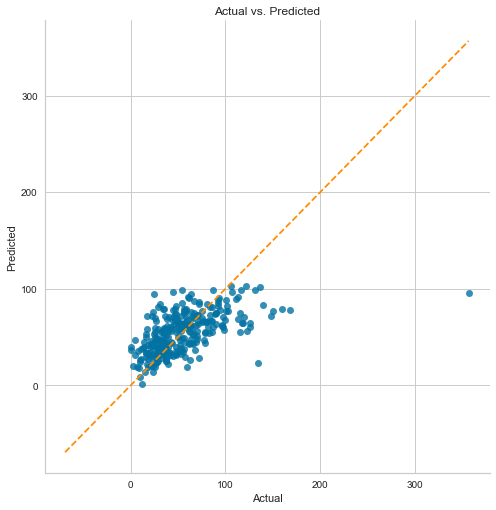

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Armin\anaconda3\lib\site-packages\statsmodels\stats\_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


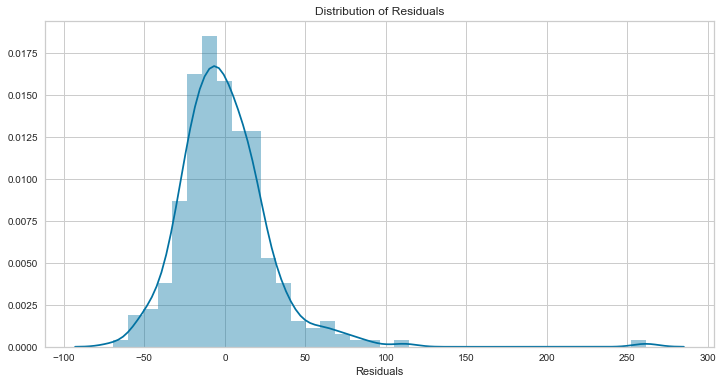


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


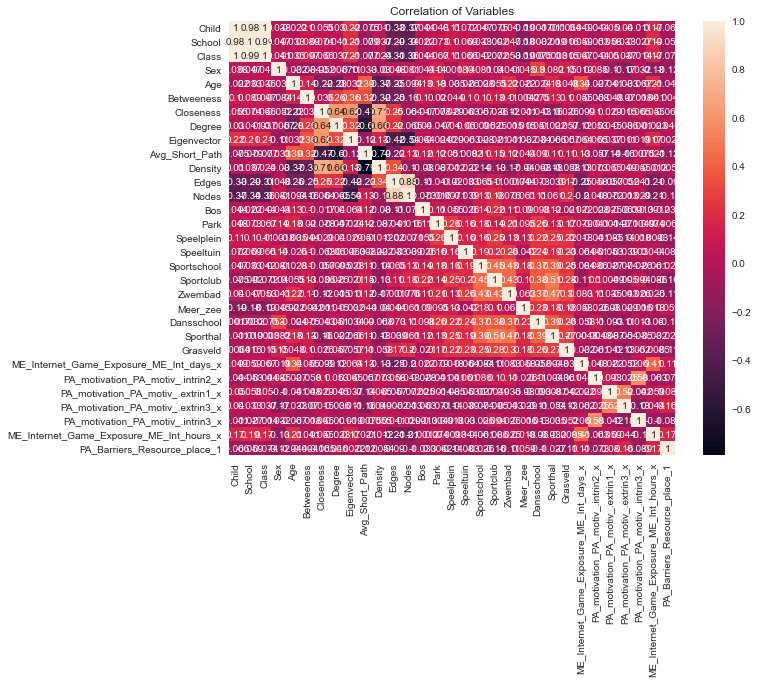

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Child: 3351.27651448534
School: 1558.7127630703978
Class: 6273.442454630937
Sex: 2.5339044482918878
Age: 238.6572158827575
Betweeness: 5.329197880081272
Closeness: 611.055114372974
Degree: 96.87833775947989
Eigenvector: 153.86339107723367
Avg_Short_Path: 220.71791751964315
Density: 375.3959997882055
Edges: 74.15975589687612
Nodes: 301.89243066833285
Bos: 1.667812327234443
Park: 2.6358203056797422
Speelplein: 3.498562698394306
Speeltuin: 6.3697183433322495
Sportschool: 2.4553510801756353
Sportclub: 3.3171610766113964
Zwembad: 3.4067396819275526
Meer_zee: 1.5330200142111141
Dansschool: 2.3147738453000355
Sporthal: 3.4690735804432684
Grasveld: 6.905098474533485
ME_Internet_Game_Exposure_ME_Int_days_x: 15.232227057323353
PA_motivation_PA_motiv_.intrin2_x: 30.88022027361654
PA_motivation_PA_motiv_.extrin1_x: 3.8

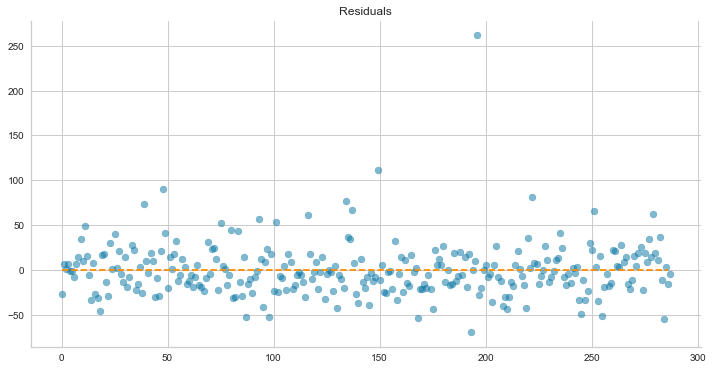

If heteroscedasticity is apparent, confidence intervals and predictions will be affected


In [12]:
ipynb.fs.full.script.linear_regression_assumptions(X, y, X.columns)

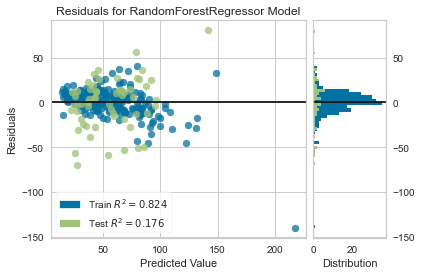

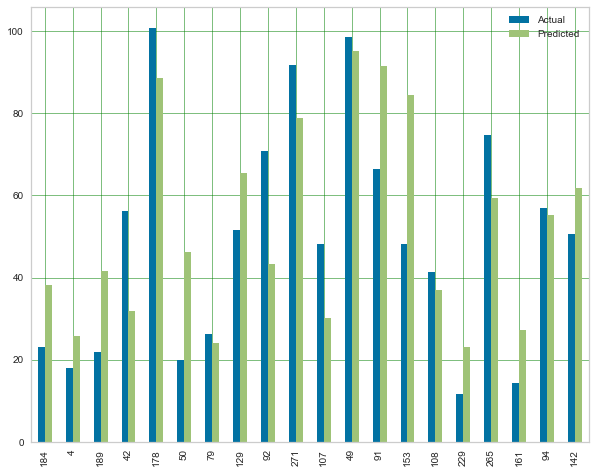

In [13]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 69)

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

visualizer = ResidualsPlot(rf)
visualizer.fit(features_train, label_train)  # Fit the training data to the visualizer
visualizer.score(features_test, label_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

predictions = visualizer.predict(features_test)
df = pd.DataFrame({'Actual': label_test, 'Predicted': predictions})
df1 = df.head(20)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [14]:
#check if 0 is male or female
full_table_13['MVPA_class'] = pd.qcut(full_table_13['Minutes_MVPA'], q=4, labels=['1', '2', '3', '4'])
temp = full_table_13[['Sex', 'Minutes_MVPA']]

temp.loc[(temp['Minutes_MVPA'] < 60), 'MVPA_class'] = 1
temp.loc[(temp['Minutes_MVPA'] > 60), 'MVPA_class'] = 2


full_table_13['MVPA_class'] = temp['MVPA_class']
temp['MVPA_class'].value_counts()


C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


1.0    184
2.0    104
Name: MVPA_class, dtype: int64

[0.81  0.562]
[0.829 0.529]


array([0.819, 0.545])

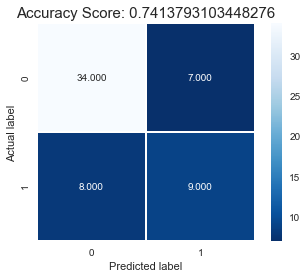

In [15]:
features = full_table_13.drop(columns = ['Minutes_MVPA','MVPA_class'])
label = full_table_13['MVPA_class']

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

rfc = RandomForestClassifier()
rfc.fit(features_train, label_train)
predictions = rfc.predict(features_test)
score = rfc.score(features_test, label_test)
prec_score = precision_score(label_test, predictions, average = None)
rec_score = recall_score(label_test, predictions, average = None)
f1 = f1_score(label_test, predictions, average = None)

s=confusion_matrix(label_test, predictions)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
print(prec_score)
print(rec_score)
f1

In [16]:
cv = KFold(n_splits=4, random_state=1, shuffle=True)
scores = cross_val_score(rfc, features, label, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.712 (0.018)


In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features_train, label_train)
rf_random.best_params_



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

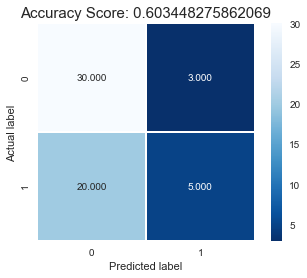

Model Performance
0.603448275862069
[0.6   0.625]
[0.909 0.2  ]
[0.723 0.303]


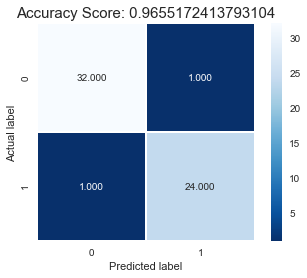

Model Performance
0.9655172413793104
[0.97 0.96]
[0.97 0.96]
[0.97 0.96]


In [18]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = model.score(test_features, test_labels)
    prec_score = precision_score(label_test, predictions, average = None)
    rec_score = recall_score(label_test, predictions, average = None)
    f1 = f1_score(label_test, predictions, average = None)
    s=confusion_matrix(label_test, predictions)
    sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
    plt.title(all_sample_title, size = 15);
    plt.show()
    print('Model Performance')
    print(accuracy)
    print(prec_score)
    print(rec_score)
    print(f1)
    return

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)
 
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(features_train, label_train)
evaluate(base_model, features_test, label_test)

best_random = rf_random.best_estimator_
evaluate(best_random, features_test, label_test)
